# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

Install Tensorboard extension for PyTorch

In [1]:
!pip install tensorboardX

In [2]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
env = UnityEnvironment(file_name='Reacher_Windows_20/Reacher')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

### 4. Train with DDPG

Using TensorBoard to visualize the results during training. It will store logs in the "runs" subdirectory of the root:

`tensorboard --logdir runs/<name_of_run> --host localhost --port 8080`

In [6]:
from ddpg_agent import Agent, N_EPISODES, MAX_T
from utils import distr_projection, RewardTracker, TBMeanTracker
import time
import torch

SOLVED_SCORE = 30
MEAN_WINDOW = 100

n_episodes = N_EPISODES
max_t = MAX_T

#agent = D4PGAgent(num_agents, state_size, action_size, 1)
agent = Agent(num_agents, state_size, action_size, 1)
max_score = -np.Inf
solved_episode = -np.Inf

# Tensorboard based reward tracker
reward_tracker = RewardTracker(agent.writer, MEAN_WINDOW)

In [7]:
for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)

    # noise reset
    #agent.reset()
    start_time = time.time()
    for t in range(max_t):
        actions = agent.act(states)

        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            agent.step(state, action, reward, next_state, done, t)             
        states = next_states

        scores += rewards

        if np.any(dones):
            break

    # does all the right things with reward tracking
    duration = time.time() - start_time
    score = np.mean(scores)
    mean_reward = reward_tracker.reward(scores, score, agent.step_t, duration)
    
    # save stuff for the report
    if i_episode == 1 or i_episode == 50 or i_episode == 100:
        torch.save(agent.actor_local.state_dict(), f'checkpoint_actor_{i_episode:03d}.pth')
        torch.save(agent.critic_local.state_dict(), f'checkpoint_critic_{i_episode:03f}.pth')
        
        max_score = score

    if mean_reward is not None and mean_reward >=  SOLVED_SCORE:
        torch.save(agent.actor_local.state_dict(), f'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), f'checkpoint_critic.pth')
        
        solved_episode = i_episode - MEAN_WINDOW
        print(f"Solved in {solved_episode} episodes")

        break

c:\anaconda3\envs\agents\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


1: reward 0.673, mean reward 0.673, min 0.060, max 1.880, duration 122.90 s
2: reward 1.566, mean reward 1.120, min 0.630, max 2.890, duration 125.99 s
3: reward 3.105, mean reward 1.782, min 1.100, max 5.010, duration 126.28 s
4: reward 3.272, mean reward 2.154, min 1.500, max 5.300, duration 126.27 s
5: reward 4.042, mean reward 2.532, min 1.750, max 7.770, duration 126.64 s
6: reward 3.982, mean reward 2.774, min 2.010, max 6.990, duration 127.77 s
7: reward 4.936, mean reward 3.083, min 3.010, max 8.480, duration 129.42 s
8: reward 5.811, mean reward 3.424, min 3.030, max 9.400, duration 129.49 s
9: reward 7.756, mean reward 3.905, min 4.610, max 12.230, duration 129.80 s
10: reward 8.748, mean reward 4.389, min 4.700, max 14.620, duration 130.58 s
11: reward 9.300, mean reward 4.836, min 5.600, max 15.300, duration 131.44 s
12: reward 11.409, mean reward 5.384, min 5.510, max 18.860, duration 132.38 s
13: reward 12.503, mean reward 5.931, min 6.090, max 16.320, duration 133.33 s
1

### 5. Visualize Results

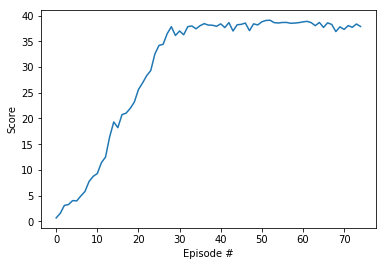

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(np.arange(len(reward_tracker.total_rewards)), reward_tracker.total_rewards, label='Rewards')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Load trained model and give it a go

In [10]:
actor_file = r'checkpoint_actor.pth'

agent = agent = Agent(num_agents, state_size, action_size, 1)
state_dict_actor = torch.load(actor_file)
agent.actor_local.load_state_dict(state_dict_actor)


In [11]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states, add_noise=False) # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

c:\anaconda3\envs\agents\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Total score (averaged over agents) this episode: 38.19949914617464


In [12]:
env.close()